<a href="https://colab.research.google.com/github/saharaty/FetalClassification/blob/main/FetalUltrasoundClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 1. Problem Statement
We classify 6 types of fetal ultrasound views to assist clinical workflows.

### 2. Dataset
- 6000 images split into train/val/test
- Resized to 224/240/300
- Augmented (horizontal flip, rotation, brightness/contrast)
- Balanced into 3 folds

### 3. Models Compared
- EfficientNet-B1  best
- EfficientNet-B3  Overfit
- ResNet50  Underperformed

### 4. Training Setup
- Backbone frozen
- Adam optimizer, CrossEntropyLoss
- Epoch-wise saving, early stopping
- Validation set for model selection

### 5. Evaluation
- B1 Accuracy: 95.27%, Loss: 0.22
- Confusion matrix showed most errors in “Other”
- Precision/Recall good for fetal brain, thorax, cervix
- F1-score chart included

### 6. Conclusion
EfficientNet-B1 provides the best trade-off between performance and generalization. Future improvements may include class-weighting, focal loss, or ensemble learning.


# Requerments

In [ ]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q efficientnet_pytorch grad-cam gdown torch torchvision torchaudio


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Standard library
import os
import sys
import random
import shutil

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models

from efficientnet_pytorch import EfficientNet
from PIL import Image, ImageOps, ImageEnhance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# Optional tools
from tqdm import tqdm
import seaborn as sns


# PreProcessing

## Dataset Setting

In [ ]:
def download_and_extract_dataset(gdrive_id, output_zip="dataset.zip", extract_to="dataset_folder"):
    if IN_COLAB:
        !gdown --id {gdrive_id} --output {output_zip}
        !mkdir -p {extract_to}
        !unzip -q {output_zip} -d {extract_to}
        !ls {extract_to}


In [ ]:
download_and_extract_dataset("1uDysoOeEToBaPKq13HxcV5_aLwXrTNcs")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1uDysoOeEToBaPKq13HxcV5_aLwXrTNcs
From (redirected): https://drive.google.com/uc?id=1uDysoOeEToBaPKq13HxcV5_aLwXrTNcs&confirm=t&uuid=f30bbc5c-418b-4b10-b48d-facc6cf87c1e
To: /content/dataset.zip
100% 2.09G/2.09G [00:24<00:00, 86.5MB/s]
content


In [ ]:
def square_pad(image):
    #Pad image to make it square using torchvision.functional
    w, h = image.size
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2
    padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
    return F.pad(image, padding, fill=0)

def pad_all_sets(base_input_dir, base_output_dir, sets=["train", "val", "test"]):
    #Pad all sets (train, val, test) and save them in padded_dataset directory
    for split in sets:
        input_dir = os.path.join(base_input_dir, split)
        output_dir = os.path.join(base_output_dir, split)
        os.makedirs(output_dir, exist_ok=True)

        for class_name in sorted(os.listdir(input_dir)):
            class_path = os.path.join(input_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            out_class_path = os.path.join(output_dir, class_name)
            os.makedirs(out_class_path, exist_ok=True)

            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    try:
                        fpath = os.path.join(class_path, fname)
                        outpath = os.path.join(out_class_path, fname)
                        img = Image.open(fpath).convert("RGB")
                        padded_img = square_pad(img)
                        padded_img.save(outpath)
                    except Exception as e:
                        print(f"Failed on {fpath}: {e}")



In [ ]:
pad_all_sets(
    base_input_dir="/content/dataset_folder/content/final_dataset",
    base_output_dir="/content/padded_dataset"
)

print("\n Padding complete.")


 Padding complete.


In [ ]:
# Define dataset split names and paths
sets = ["train", "val", "test"]
base_input_dir = "/content/dataset_folder/content/final_dataset"
base_output_dir = "/content/padded_dataset"


In [ ]:
print("Original → Padded image count check:")

for split in sets:
    original_dir = os.path.join(base_input_dir, split)
    padded_dir = os.path.join(base_output_dir, split)

    original_count = sum(
        len([f for f in os.listdir(os.path.join(original_dir, cls)) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        for cls in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, cls))
    )

    padded_count = sum(
        len([f for f in os.listdir(os.path.join(padded_dir, cls)) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        for cls in os.listdir(padded_dir) if os.path.isdir(os.path.join(padded_dir, cls))
    )

    print(f"{split.upper()} set: {original_count} → {padded_count}")


Original → Padded image count check:
TRAIN set: 8674 → 8674
VAL set: 1860 → 1860
TEST set: 1861 → 1861


## Analysis

In [ ]:
def compute_brightness(padded_dir):
    means = []
    labels = []
    image_paths = []

    for class_name in sorted(os.listdir(padded_dir)):
        class_path = os.path.join(padded_dir, class_name)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    fpath = os.path.join(class_path, fname)
                    try:
                        img = Image.open(fpath).convert("L")
                        pixel_values = list(img.getdata())
                        mean_brightness = sum(pixel_values) / len(pixel_values)
                        means.append(mean_brightness)
                        labels.append(class_name)
                        image_paths.append(fpath)
                    except:
                        print(f"Failed to read: {fpath}")

    return image_paths, labels, means


In [ ]:
image_paths, labels, means = compute_brightness("/content/padded_dataset/train")


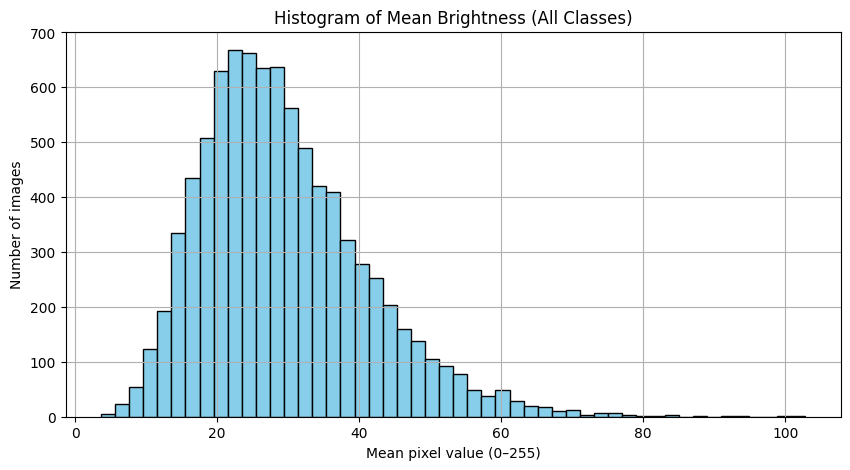

In [ ]:
  plt.figure(figsize=(10, 5))
  plt.hist(means, bins=50, color='skyblue', edgecolor='black')
  plt.title("Histogram of Mean Brightness (All Classes)")
  plt.xlabel("Mean pixel value (0–255)")
  plt.ylabel("Number of images")
  plt.grid(True)
  plt.show()


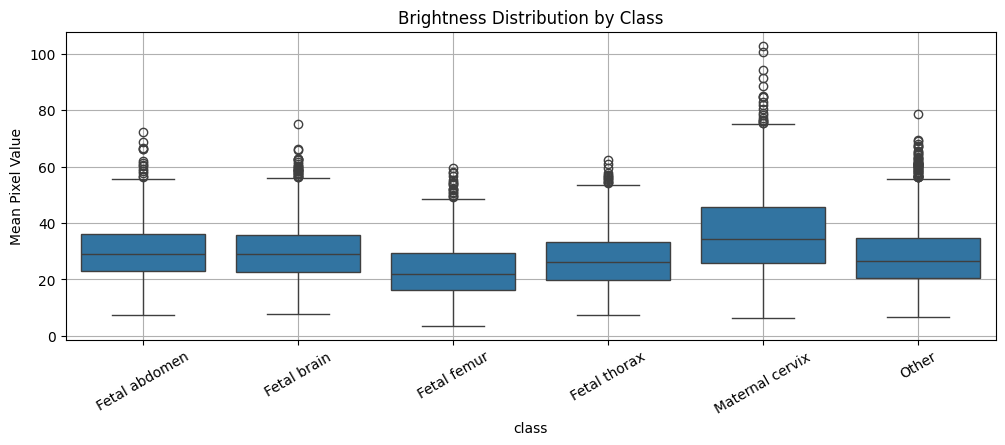

In [ ]:
df = pd.DataFrame({"brightness": means, "class": labels})

plt.figure(figsize=(12, 4))
sns.boxplot(data=df, x='class', y='brightness')
plt.title("Brightness Distribution by Class")
plt.ylabel("Mean Pixel Value")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()


In [ ]:
def count_overbright(images, labels, means, brightness_threshold=80, target_class="Maternal cervix"):
    count = sum(
        1 for i in range(len(images))
        if labels[i] == target_class and means[i] >= brightness_threshold
    )
    print(f"{count} images in class '{target_class}' have brightness ≥ {brightness_threshold}")


In [ ]:
count_overbright(image_paths, labels, means)


11 images in class 'Maternal cervix' have brightness ≥ 80


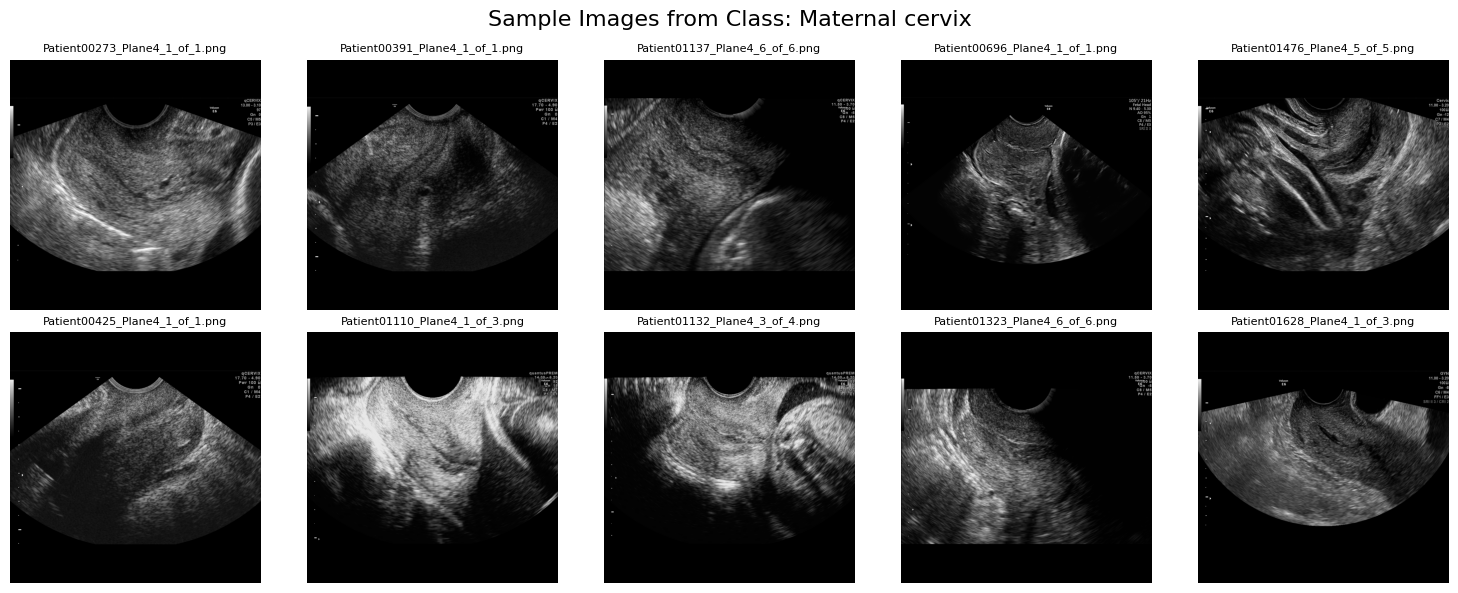

In [ ]:
# Maternal cervix
MC_class_path = "/content/padded_dataset/train/Maternal cervix"

MC_images = [
    f for f in os.listdir(MC_class_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# 10 random samples
sampled = random.sample(MC_images, 10)

plt.figure(figsize=(15, 6))
for i, fname in enumerate(sampled):
    img = Image.open(os.path.join(MC_class_path, fname))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(fname, fontsize=8)
    plt.axis("off")
plt.suptitle("Sample images from class: Maternal cervix", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
def delete_overbright_images(image_paths, labels, brightness_means, threshold=100, target_class="Maternal cervix"):
    deleted_count = 0
    for i in range(len(image_paths)):
        if labels[i] == target_class and brightness_means[i] >= threshold:
            try:
                os.remove(image_paths[i])
                deleted_count += 1
                print(f"Deleted: {image_paths[i]}")
            except Exception as e:
                print(f"Failed to delete {image_paths[i]}: {e}")
    print(f"\nDeleted {deleted_count} images with brightness ≥ {threshold} in class '{target_class}'.")


In [ ]:
delete_overbright_images(image_paths, labels, means)


Deleted: /content/padded_dataset/train/Maternal cervix/Patient00277_Plane4_1_of_1.png
Deleted: /content/padded_dataset/train/Maternal cervix/Patient00383_Plane4_1_of_1.png

Deleted 2 images with brightness ≥ 100 in class 'Maternal cervix'.


In [ ]:
def adjust_brightness_images(image_paths, labels, brightness_means, min_val=80, max_val=100, target_class="Maternal cervix"):
    adjusted_count = 0
    for i in range(len(image_paths)):
        if labels[i] == target_class and min_val <= brightness_means[i] < max_val:
            try:
                img = Image.open(image_paths[i]).convert("RGB")
                enhancer = ImageEnhance.Brightness(img)
                darker_img = enhancer.enhance(0.7)
                darker_img.save(image_paths[i])
                adjusted_count += 1
                print(f"Adjusted: {image_paths[i]}")
            except Exception as e:
                print(f"Failed to adjust {image_paths[i]}: {e}")
    print(f"\nAdjusted brightness for {adjusted_count} images in class '{target_class}' with brightness between {min_val} and {max_val}.")


In [ ]:
adjust_brightness_images(image_paths, labels, means)


Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00438_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00265_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00455_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00262_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00378_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00267_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00234_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00232_Plane4_1_of_1.png
Adjusted: /content/padded_dataset/train/Maternal cervix/Patient00206_Plane4_1_of_1.png

Adjusted brightness for 9 images in class 'Maternal cervix' with brightness between 80 and 100.


In [ ]:
image_paths, labels, means = compute_brightness("/content/padded_dataset/train")


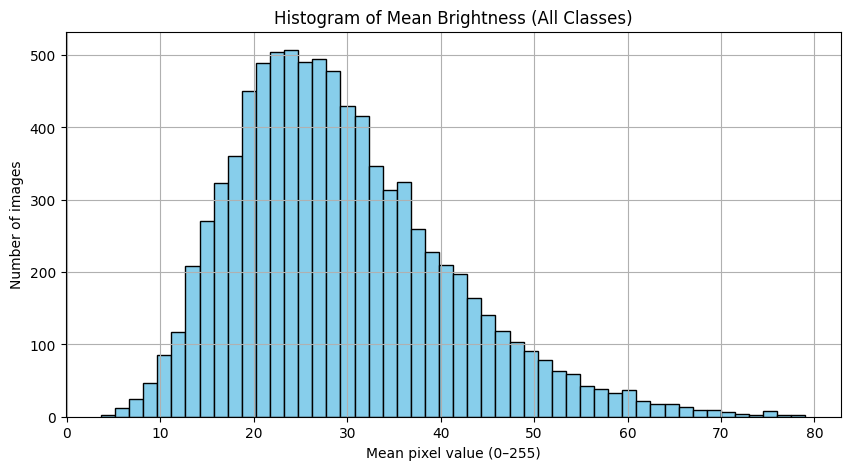

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(means, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Mean Brightness (All Classes)")
plt.xlabel("Mean pixel value (0–255)")
plt.ylabel("Number of images")
plt.grid(True)
plt.show()


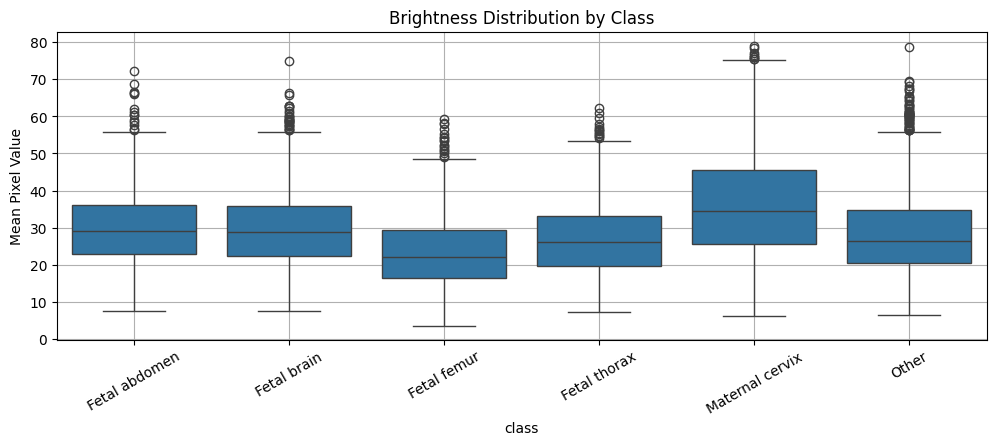

In [ ]:
df = pd.DataFrame({"brightness": means, "class": labels})

plt.figure(figsize=(12, 4))
sns.boxplot(data=df, x='class', y='brightness')
plt.title("Brightness Distribution by Class")
plt.ylabel("Mean Pixel Value")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()


In [ ]:
df = pd.DataFrame({
    "image_path": image_paths,
    "class": labels,
    "brightness": means
})

df.to_csv("brightness_analysis.csv", index=False)
print("Saved brightness_analysis.csv")

Saved brightness_analysis.csv


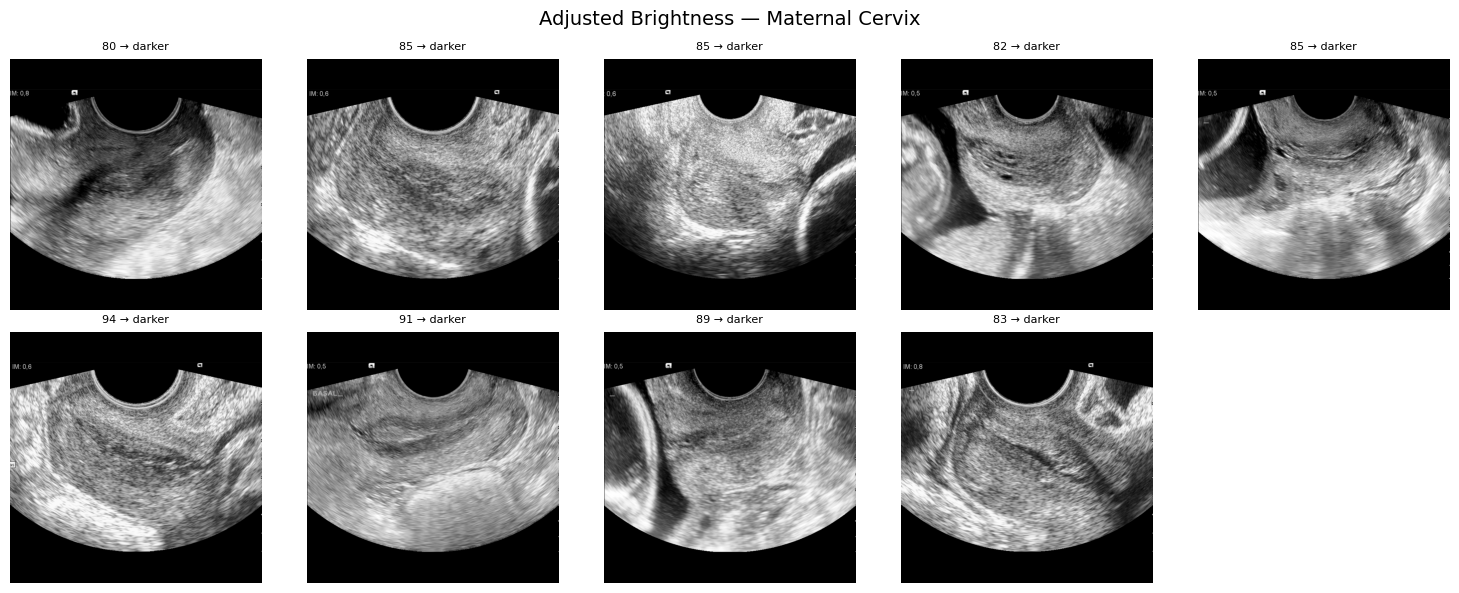

In [ ]:

adjusted_imgs = [image_paths[i] for i, m in enumerate(means) if 80 <= m < 100 and labels[i] == "Maternal cervix"]
adjusted_vals = [round(means[i]) for i, m in enumerate(means) if 80 <= m < 100 and labels[i] == "Maternal cervix"]

plt.figure(figsize=(15, 6))
for i, path in enumerate(adjusted_imgs):
    img = Image.open(path).convert("L")
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{adjusted_vals[i]} → darker", fontsize=8)
    plt.axis("off")

plt.suptitle("Adjusted Brightness — Maternal Cervix", fontsize=14)
plt.tight_layout()
plt.show()

# Augmentation

In [ ]:
def augment_and_save(input_dir, output_dir, augment_per_image=1):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ])

    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_input_path = os.path.join(input_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for img_name in os.listdir(class_input_path):
            img_path = os.path.join(class_input_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
            except:
                print(f"Failed to open {img_path}")
                continue

            # Save original image
            image.save(os.path.join(class_output_path, img_name))

            # Generate augmented versions
            for i in range(augment_per_image):
                aug_img = transform(image)
                aug_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
                aug_img.save(os.path.join(class_output_path, aug_name))


In [ ]:
padded_train_dir = "/content/padded_dataset/train"
augmented_train_dir = "/content/augmented_dataset/train"
augment_and_save(padded_train_dir, augmented_train_dir)


In [ ]:
# Source and target directories
original_val_dir = "/content/padded_dataset/val"
original_test_dir = "/content/padded_dataset/test"

target_val_dir = "/content/augmented_dataset/val"
target_test_dir = "/content/augmented_dataset/test"

# Move validation and test sets to match the augmented train set structure
def copy_dataset(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for class_name in os.listdir(src_dir):
        src_class = os.path.join(src_dir, class_name)
        dst_class = os.path.join(dst_dir, class_name)
        if os.path.isdir(src_class):
            shutil.copytree(src_class, dst_class, dirs_exist_ok=True)

copy_dataset(original_val_dir, target_val_dir)
copy_dataset(original_test_dir, target_test_dir)

print("Validation and test sets copied to augmented_dataset directory.")


Validation and test sets copied to augmented_dataset directory.


## Resizing

In [ ]:
def resize_dataset(source_base, dest_base, target_size):
    splits = ["train", "val", "test"]

    for split in splits:
        src_path = os.path.join(source_base, split)
        dst_path = os.path.join(dest_base, split)
        os.makedirs(dst_path, exist_ok=True)

        for class_name in os.listdir(src_path):
            class_src = os.path.join(src_path, class_name)
            class_dst = os.path.join(dst_path, class_name)
            os.makedirs(class_dst, exist_ok=True)

            for fname in os.listdir(class_src):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    src_file = os.path.join(class_src, fname)
                    dst_file = os.path.join(class_dst, fname)

                    try:
                        img = Image.open(src_file).convert("RGB")
                        img = img.resize((target_size, target_size))
                        img.save(dst_file)
                    except Exception as e:
                        print(f"Error with {src_file}: {e}")


In [ ]:
resize_dataset(
    source_base="/content/augmented_dataset",
    dest_base="/content/resized_dataset_240",
    target_size=240
)

resize_dataset(
    source_base="/content/augmented_dataset",
    dest_base="/content/resized_dataset_300",
    target_size=300
)

resize_dataset(
    source_base="/content/augmented_dataset",
    dest_base="/content/resized_dataset_224",
    target_size=224
)


# Model Defenition

##DataLoader

In [ ]:
def create_dataloaders_named(name, base_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_set = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform)
    val_set   = datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform)
    test_set  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform)

    loaders = {
        f"train_{name}": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        f"val_{name}":   DataLoader(val_set, batch_size=batch_size, shuffle=False),
        f"test_{name}":  DataLoader(test_set, batch_size=batch_size, shuffle=False)
    }

    return loaders


##Models

In [ ]:
def build_model(backbone_name, num_classes):
    if backbone_name == "efficientnet_b1":
        model = models.efficientnet_b1(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif backbone_name == "efficientnet_b3":
        model = models.efficientnet_b3(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif backbone_name == "resnet50":
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze only the classifier
    for name, param in model.named_parameters():
        if "classifier" in name or "fc" in name:
            param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    return model, device


In [ ]:
loaders_b1 = create_dataloaders_named("b1", "/content/resized_dataset_240")
loaders_b3 = create_dataloaders_named("b3", "/content/resized_dataset_300")
loaders_rn = create_dataloaders_named("resnet", "/content/resized_dataset_224")


In [ ]:
num_classes = len(loaders_b1["train_b1"].dataset.classes)

models_dict = {}

for name, loaders in [("b1", loaders_b1), ("b3", loaders_b3), ("resnet", loaders_rn)]:
    backbone = f"efficientnet_{name}" if name in ["b1", "b3"] else "resnet50"

    model, device = build_model(backbone, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    models_dict[name] = {
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "device": device,
        "loaders": loaders
    }


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 119MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights

#Training

In [ ]:
def train_model(model, loaders, optimizer, scheduler, device, model_name, num_epochs=10):
    train_loader = loaders[f"train_{model_name}"]
    val_loader   = loaders[f"val_{model_name}"]

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}] — Model: {model_name}")
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Update scheduler
        scheduler.step(val_loss)

        # Save model after each epoch
        save_path = f"{model_name}_epoch{epoch+1}.pt"
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

        # Save best model separately
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best.pt")
            print("New best model saved.")


In [ ]:
len(models_dict["b1"]["loaders"]["train_b1"].dataset)


17344

In [ ]:
train_model(
    model=models_dict["b1"]["model"],
    loaders=models_dict["b1"]["loaders"],
    optimizer=models_dict["b1"]["optimizer"],
    scheduler=models_dict["b1"]["scheduler"],
    device=models_dict["b1"]["device"],
    model_name="b1",
    num_epochs=10
)



Epoch [1/10] — Model: b1
Train Loss: 0.0619 | Train Acc: 0.9785
Val Loss:   0.2193 | Val Acc:   0.9435
Model saved to b1_epoch1.pt
New best model saved.

Epoch [2/10] — Model: b1
Train Loss: 0.0509 | Train Acc: 0.9824
Val Loss:   0.2135 | Val Acc:   0.9484
Model saved to b1_epoch2.pt
New best model saved.

Epoch [3/10] — Model: b1
Train Loss: 0.0310 | Train Acc: 0.9893
Val Loss:   0.2066 | Val Acc:   0.9462
Model saved to b1_epoch3.pt

Epoch [4/10] — Model: b1
Train Loss: 0.0225 | Train Acc: 0.9929
Val Loss:   0.2233 | Val Acc:   0.9489
Model saved to b1_epoch4.pt
New best model saved.

Epoch [5/10] — Model: b1
Train Loss: 0.0211 | Train Acc: 0.9934
Val Loss:   0.2398 | Val Acc:   0.9478
Model saved to b1_epoch5.pt

Epoch [6/10] — Model: b1
Train Loss: 0.0180 | Train Acc: 0.9946
Val Loss:   0.2365 | Val Acc:   0.9484
Model saved to b1_epoch6.pt

Epoch [7/10] — Model: b1
Train Loss: 0.0178 | Train Acc: 0.9944
Val Loss:   0.2412 | Val Acc:   0.9473
Model saved to b1_epoch7.pt

Epoch [8/

In [ ]:
train_model(
    model=models_dict["b3"]["model"],
    loaders=models_dict["b3"]["loaders"],
    optimizer=models_dict["b3"]["optimizer"],
    scheduler=models_dict["b3"]["scheduler"],
    device=models_dict["b3"]["device"],
    model_name="b3",
    num_epochs=10
)



Epoch [1/10] — Model: b3
Train Loss: 0.2927 | Train Acc: 0.9024
Val Loss:   0.1510 | Val Acc:   0.9446
Model saved to b3_epoch1.pt
New best model saved.

Epoch [2/10] — Model: b3
Train Loss: 0.1312 | Train Acc: 0.9540
Val Loss:   0.1492 | Val Acc:   0.9548
Model saved to b3_epoch2.pt
New best model saved.

Epoch [3/10] — Model: b3
Train Loss: 0.0994 | Train Acc: 0.9664
Val Loss:   0.1577 | Val Acc:   0.9495
Model saved to b3_epoch3.pt

Epoch [4/10] — Model: b3
Train Loss: 0.0745 | Train Acc: 0.9750
Val Loss:   0.1746 | Val Acc:   0.9435
Model saved to b3_epoch4.pt

Epoch [5/10] — Model: b3
Train Loss: 0.0640 | Train Acc: 0.9759
Val Loss:   0.1981 | Val Acc:   0.9505
Model saved to b3_epoch5.pt

Epoch [6/10] — Model: b3
Train Loss: 0.0384 | Train Acc: 0.9870
Val Loss:   2.4214 | Val Acc:   0.9462
Model saved to b3_epoch6.pt

Epoch [7/10] — Model: b3
Train Loss: 0.0300 | Train Acc: 0.9906
Val Loss:   0.1921 | Val Acc:   0.9495
Model saved to b3_epoch7.pt

Epoch [8/10] — Model: b3
Train 

In [ ]:
train_model(
    model=models_dict["resnet"]["model"],
    loaders=models_dict["resnet"]["loaders"],
    optimizer=models_dict["resnet"]["optimizer"],
    scheduler=models_dict["resnet"]["scheduler"],
    device=models_dict["resnet"]["device"],
    model_name="resnet",
    num_epochs=10
)



Epoch [1/10] — Model: resnet
Train Loss: 0.6287 | Train Acc: 0.7837
Val Loss:   0.4530 | Val Acc:   0.8473
Model saved to resnet_epoch1.pt
New best model saved.

Epoch [2/10] — Model: resnet
Train Loss: 0.4354 | Train Acc: 0.8420
Val Loss:   0.3595 | Val Acc:   0.8731
Model saved to resnet_epoch2.pt
New best model saved.

Epoch [3/10] — Model: resnet
Train Loss: 0.4074 | Train Acc: 0.8537
Val Loss:   0.3522 | Val Acc:   0.8817
Model saved to resnet_epoch3.pt
New best model saved.

Epoch [4/10] — Model: resnet
Train Loss: 0.3903 | Train Acc: 0.8625
Val Loss:   0.3568 | Val Acc:   0.8634
Model saved to resnet_epoch4.pt

Epoch [5/10] — Model: resnet
Train Loss: 0.3730 | Train Acc: 0.8659
Val Loss:   0.3605 | Val Acc:   0.8726
Model saved to resnet_epoch5.pt

Epoch [6/10] — Model: resnet
Train Loss: 0.3625 | Train Acc: 0.8683
Val Loss:   0.3250 | Val Acc:   0.8844
Model saved to resnet_epoch6.pt
New best model saved.

Epoch [7/10] — Model: resnet
Train Loss: 0.3516 | Train Acc: 0.8737
Val

#Teseting the models

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    loss_total = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_total += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = loss_total / total
    test_acc = correct / total
    return test_loss, test_acc


In [ ]:
model_names = ["b1", "b3", "resnet"]
results = {}

for name in model_names:
    print(f"\n--- Testing {name.upper()} ---")

    model = models_dict[name]["model"]
    device = models_dict[name]["device"]
    test_loader = models_dict[name]["loaders"][f"test_{name}"]

    # Load best weights
    model.load_state_dict(torch.load(f"{name}_best.pt"))

    # Evaluate
    test_loss, test_acc = test_model(model, test_loader, device)
    results[name] = {"loss": test_loss, "acc": test_acc}

    print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")



--- Testing B1 ---
Test Accuracy: 0.9527 | Test Loss: 0.2212

--- Testing B3 ---
Test Accuracy: 0.9586 | Test Loss: 2.2607

--- Testing RESNET ---
Test Accuracy: 0.8818 | Test Loss: 0.3360


In [ ]:
print("\n Final Test Results:")
for name, metrics in results.items():
    print(f"{name.upper():>8}: Accuracy = {metrics['acc']:.4f} | Loss = {metrics['loss']:.4f}")



 Final Test Results:
      B1: Accuracy = 0.9527 | Loss = 0.2212
      B3: Accuracy = 0.9586 | Loss = 2.2607
  RESNET: Accuracy = 0.8818 | Loss = 0.3360


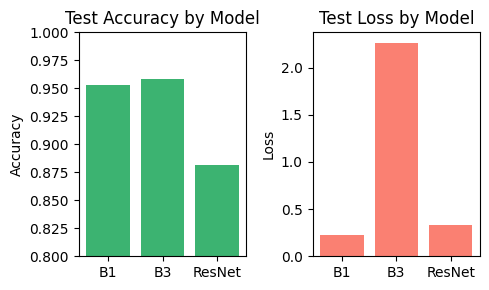

In [ ]:
# Model names and metrics
models = ['B1', 'B3', 'ResNet']
accuracies = [0.9527, 0.9586, 0.8818]
losses = [0.2212, 2.2607, 0.3360]

# Create a plot with two subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

# Accuracy bar chart
axs[0].bar(models, accuracies, color='mediumseagreen')
axs[0].set_ylim(0.8, 1.0)
axs[0].set_title('Test Accuracy by Model')
axs[0].set_ylabel('Accuracy')

# Loss bar chart
axs[1].bar(models, losses, color='salmon')
axs[1].set_title('Test Loss by Model')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()


In [ ]:
def compute_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name.upper()}")
    plt.tight_layout()
    plt.show()


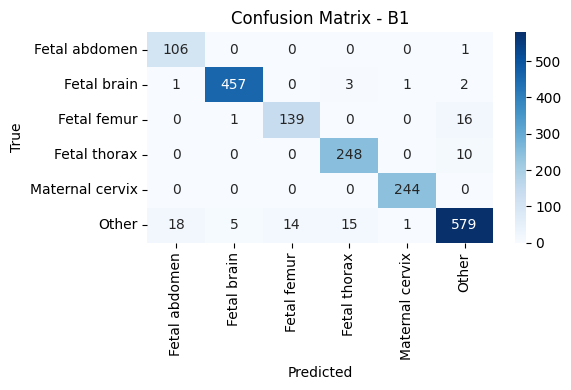

In [ ]:
class_names = models_dict["b1"]["loaders"]["train_b1"].dataset.classes
cm_b1 = compute_confusion_matrix(models_dict["b1"]["model"], models_dict["b1"]["loaders"]["test_b1"], class_names, device)
plot_confusion_matrix(cm_b1, class_names, model_name="b1")


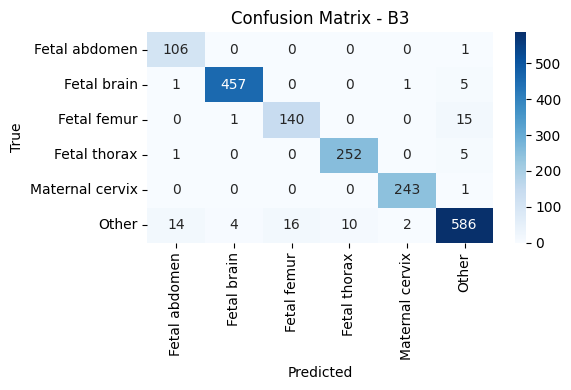

In [ ]:
class_names = models_dict["b3"]["loaders"]["train_b3"].dataset.classes
cm_b3 = compute_confusion_matrix(models_dict["b3"]["model"], models_dict["b3"]["loaders"]["test_b3"], class_names, device)
plot_confusion_matrix(cm_b3, class_names, model_name="b3")


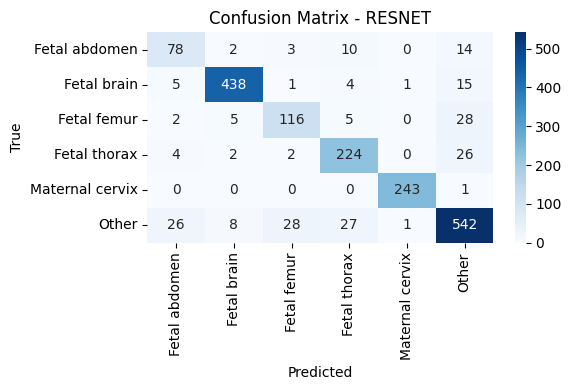

In [ ]:
class_names = models_dict["resnet"]["loaders"]["train_resnet"].dataset.classes
cm_resnet = compute_confusion_matrix(models_dict["resnet"]["model"], models_dict["resnet"]["loaders"]["test_resnet"], class_names, device)
plot_confusion_matrix(cm_resnet, class_names, model_name="resnet")


In [ ]:
def evaluate_classification_report(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)


In [ ]:
evaluate_classification_report(
    model=models_dict["b1"]["model"],
    dataloader=models_dict["b1"]["loaders"]["test_b1"],
    class_names=models_dict["b1"]["loaders"]["train_b1"].dataset.classes,
    device=device
)


                 precision    recall  f1-score   support

  Fetal abdomen       0.85      0.99      0.91       107
    Fetal brain       0.99      0.98      0.99       464
    Fetal femur       0.91      0.89      0.90       156
   Fetal thorax       0.93      0.96      0.95       258
Maternal cervix       0.99      1.00      1.00       244
          Other       0.95      0.92      0.93       632

       accuracy                           0.95      1861
      macro avg       0.94      0.96      0.95      1861
   weighted avg       0.95      0.95      0.95      1861



In [ ]:
evaluate_classification_report(
    model=models_dict["b3"]["model"],
    dataloader=models_dict["b3"]["loaders"]["test_b3"],
    class_names=models_dict["b3"]["loaders"]["train_b3"].dataset.classes,
    device=device
)


                 precision    recall  f1-score   support

  Fetal abdomen       0.87      0.99      0.93       107
    Fetal brain       0.99      0.98      0.99       464
    Fetal femur       0.90      0.90      0.90       156
   Fetal thorax       0.96      0.98      0.97       258
Maternal cervix       0.99      1.00      0.99       244
          Other       0.96      0.93      0.94       632

       accuracy                           0.96      1861
      macro avg       0.94      0.96      0.95      1861
   weighted avg       0.96      0.96      0.96      1861



In [ ]:
evaluate_classification_report(
    model=models_dict["resnet"]["model"],
    dataloader=models_dict["resnet"]["loaders"]["test_resnet"],
    class_names=models_dict["resnet"]["loaders"]["train_resnet"].dataset.classes,
    device=device
)


                 precision    recall  f1-score   support

  Fetal abdomen       0.68      0.73      0.70       107
    Fetal brain       0.96      0.94      0.95       464
    Fetal femur       0.77      0.74      0.76       156
   Fetal thorax       0.83      0.87      0.85       258
Maternal cervix       0.99      1.00      0.99       244
          Other       0.87      0.86      0.86       632

       accuracy                           0.88      1861
      macro avg       0.85      0.86      0.85      1861
   weighted avg       0.88      0.88      0.88      1861



In [ ]:
def plot_classification_metrics(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=np.arange(len(class_names)))

    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(x - width, precision, width, label='Precision')
    ax.bar(x, recall, width, label='Recall')
    ax.bar(x + width, f1, width, label='F1-score')

    ax.set_ylabel('Score')
    ax.set_title('Precision, Recall and F1-Score by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()


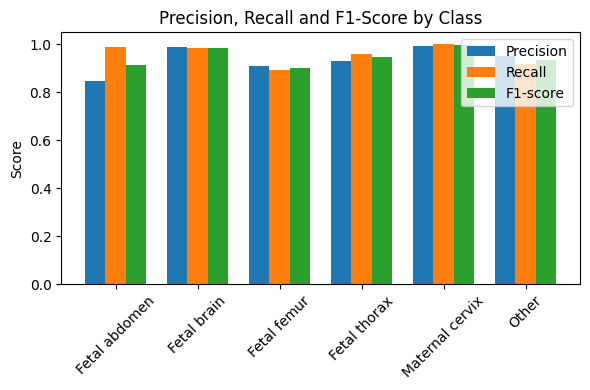

In [ ]:
plot_classification_metrics(
    model=models_dict["b1"]["model"],
    dataloader=models_dict["b1"]["loaders"]["test_b1"],
    class_names=models_dict["b1"]["loaders"]["train_b1"].dataset.classes,
    device=models_dict["b1"]["device"]
)


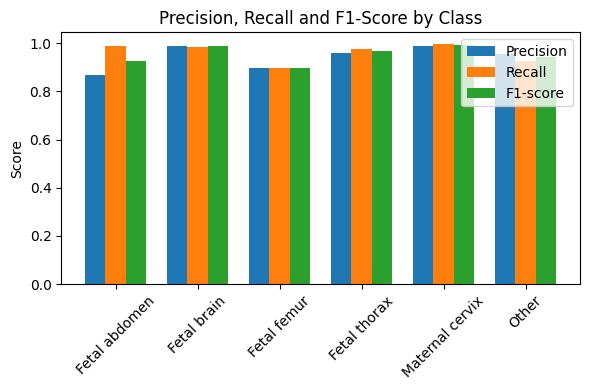

In [ ]:
plot_classification_metrics(
    model=models_dict["b3"]["model"],
    dataloader=models_dict["b3"]["loaders"]["test_b3"],
    class_names=models_dict["b3"]["loaders"]["train_b3"].dataset.classes,
    device=models_dict["b3"]["device"]
)


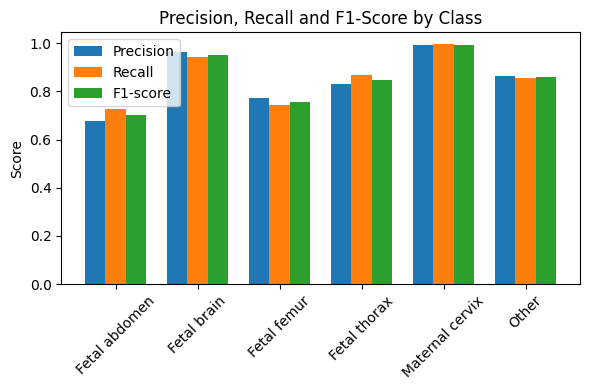

In [ ]:
plot_classification_metrics(
    model=models_dict["resnet"]["model"],
    dataloader=models_dict["resnet"]["loaders"]["test_resnet"],
    class_names=models_dict["resnet"]["loaders"]["train_resnet"].dataset.classes,
    device=models_dict["resnet"]["device"]
)


#Saving the model

In [ ]:
torch.save(models_dict["b1"]["model"].state_dict(), "final_fetal_model_b1.pt")


In [ ]:
def predict_image(image_path, model, class_names, device, image_size=224):
    # 1. Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]) if model.__class__.__name__.startswith("EfficientNet") else transforms.Normalize([0.485, 0.456, 0.406],
                                                                                                                             [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 2. Run model inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    # 3. Show prediction
    pred_class = class_names[pred_idx.item()]
    confidence = conf.item()

    # 4. Display image with predicted label
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Prediction: {pred_class} ({confidence:.2%})')
    plt.show()

    return pred_class, confidence


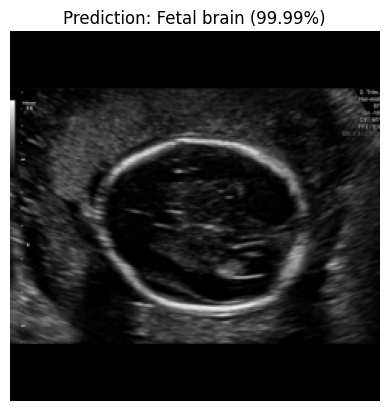

('Fetal brain', 0.9999096393585205)

In [ ]:
predict_image(
    image_path="/content/resized_dataset_240/test/Fetal brain/Patient00216_Plane3_2_of_5.png",
    model=models_dict["b1"]["model"],
    class_names=models_dict["b1"]["loaders"]["train_b1"].dataset.classes,
    device=models_dict["b1"]["device"],
    image_size=240
)


#Interpretability Analysis

In [ ]:
# 2Define transforms
padding_transform = transforms.Lambda(lambda img: ImageOps.pad(img, (max(img.size), max(img.size)), color=(0, 0, 0)))

def adjust_brightness(img):
    img_gray = img.convert("L")
    mean_brightness = sum(img_gray.getdata()) / (img_gray.width * img_gray.height)
    factor = 100 / mean_brightness if mean_brightness > 0 else 1
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

brightness_adjustment = transforms.Lambda(adjust_brightness)


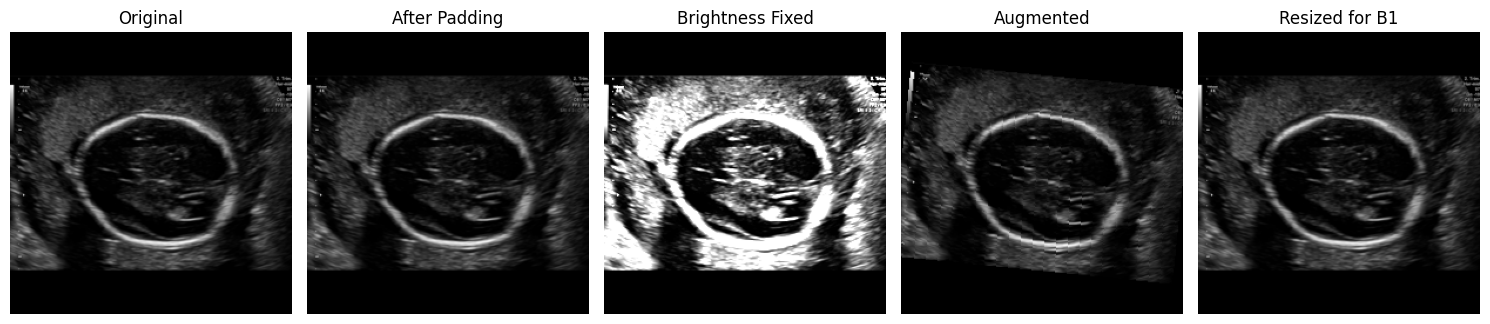

In [ ]:
visualize_pipeline_steps(
    image_path="/content/resized_dataset_240/test/Fetal brain/Patient00216_Plane3_2_of_5.png",
    transforms_list=[
        transforms.Compose([]),  # original
        transforms.Compose([padding_transform]),
        transforms.Compose([brightness_adjustment]),
        transforms.Compose([transforms.RandomRotation(10), transforms.RandomHorizontalFlip()]),
        transforms.Compose([transforms.Resize((240, 240))])
    ],
    titles=[
        "Original",
        "After Padding",
        "Brightness Fixed",
        "Augmented",
        "Resized for B1"
    ]
)


In [ ]:
!pip install pytorch-grad-cam


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image
import cv2



In [ ]:
model = models_dict["b1"]["model"]
target_layer = model.features[-1]  # Last Conv layer for EfficientNet-B1

# Load and preprocess a sample image
img_path = "/content/resized_dataset_240/test/Fetal brain/Patient00216_Plane3_2_of_5.png"
image = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
input_tensor = transform(image).unsqueeze(0).to(device)

# create the raw RGB image (rescaled to [0,1]) for overlay
rgb_image = np.array(image.resize((240, 240))).astype(np.float32) / 255.0


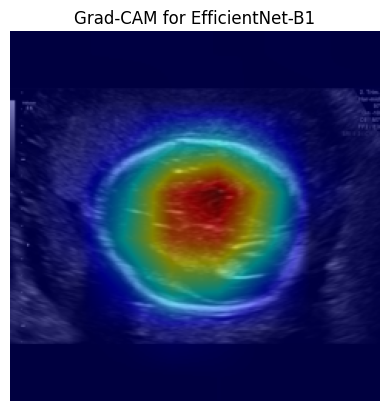

In [ ]:
# Setup
model.eval()
target_layer = model.features[-1]  # EfficientNet-B1 last conv layer

# Create GradCAM object (no use_cuda anymore)
cam = GradCAM(model=model, target_layers=[target_layer])

# Move input to device
input_tensor = input_tensor.to(device)

# Run Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]  # First image

# Overlay CAM on image
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# Plot
import matplotlib.pyplot as plt
plt.imshow(visualization)
plt.title("Grad-CAM for EfficientNet-B1")
plt.axis("off")
plt.show()


In [ ]:
gradcam = GradCAM(model=models_dict["b1"]["model"], target_layers=[target_layer])


In [ ]:
test_loader = models_dict["b1"]["loaders"]["test_b1"]
class_names = test_loader.dataset.classes
seen_classes = set()
images = []

for inputs, labels in test_loader:
    for img, label in zip(inputs, labels):
        if label.item() not in seen_classes:
            images.append((img.unsqueeze(0), label.item()))
            seen_classes.add(label.item())
        if len(seen_classes) == len(class_names):
            break
    if len(seen_classes) == len(class_names):
        break
